In [1]:
import cv2 
import numpy as np

In [2]:
img= cv2.imread('test6.jpg')
img.shape

(704, 1279, 3)

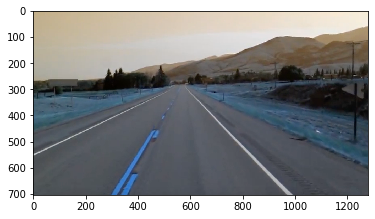

In [3]:
import matplotlib.pyplot as plt
plt.imshow(img, cmap= 'gray')

In [4]:
def coordinate_generator( image, line_parameters):
    
    """ The function collects the line_parameters value (i.e. the average of all slopes)
        from average_slope_intercept function and unpack it.
        y1 is set to the max row number. y2 is set to 3/5 times of y1.
        x1 is (y1- c)/m. x2 is (y2-c)/m.
        y= mx + c :- m is slope; c is intercept    
    """
    
    m, c= line_parameters
    y1= image.shape[0]
    y2= int(y1 * (3/5))
    x1= int((y1-c)/m)
    x2= int((y2-c)/m)
    return np.array([x1, y1, x2, y2])

In [5]:
def avg_line_generator(image, lines):
    """ This function averages out the slopes and y intercepts into a single line."""
    # left and right fit are 2 lists that collect the coordinates of the average value 
    # of the lineson the left and the right sides.
    left_fit= []
    right_fit= []
    
    # Here we looped all lines and reshaped them into a 4-D array using line.reshape(4)
    for line in lines:
        x1, y1, x2, y2= line.reshape(4)
        
        # Using polyfit for fitting a 1st degree polynomial (linear function)
        parameter= np.polyfit( (x1,x2), (y1, y2), 1 )
        
        # x and y returns a vector of coefficients slope and intercept.
        m= parameter[0]
        c= parameter[1]
        
        # Value of slope is negative for lines on the left side and positive for the one on the right.
        if m < 0:
            left_fit.append((m, c))
        else:
            right_fit.append((m, c))
    # Computing the average of the intercepts of the left and the right.
    left_fit_avg= np.average(left_fit, axis=0)
    right_fit_avg= np.average(right_fit, axis=0)
    
    # Computing the x and y coordinates of the line using make_coordinates.
    left_line= coordinate_generator(image, left_fit_avg)
    right_line= coordinate_generator(image, right_fit_avg)
    
    return np.array( [left_line, right_line] )
        

In [6]:
def edge_detector(image):
    gray_conversion= cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
    blur_conversion = cv2.GaussianBlur(gray_conversion, (5,5),0)
    canny_conversion = cv2.Canny(blur_conversion, 50,150)
    return canny_conversion

In [7]:
def show_lines(image, lines):
    line_image = np.zeros_like(image)
    if lines is not None:
            for line in lines:
                x1, y1, x2, y2 = line.reshape(4)
                cv2.line(line_image, (x1, y1), (x2, y2), (255,0,0), 10)
    return line_image      

In [8]:
def roi(image):
    image_height = image.shape[0]
    polygons = np.array([[(200, image_height), (1100, image_height), (550, 250)]])
    image_mask = np.zeros_like(image)
    cv2.fillPoly(image_mask, polygons, 255)
    masking_image = cv2.bitwise_and(image,image_mask)
    return masking_image

In [ ]:
cap = cv2.VideoCapture("rmd_video.mp4")

while(cap.isOpened()):
            _, frame = cap.read()
            # 1 Detecting Edges
            canny_img = edge_detector(frame)
            # 2 Marking the region of interest
            cropped_canny = roi(canny_img)
            # 3 Implementing hough transformation
            lines = cv2.HoughLinesP(cropped_canny, 2, np.pi/180, 100,         
                                    np.array([]), minLineLength=40,maxLineGap=5)
            # 4 Generating a single line on either sides of the road.
            avg_lines = avg_line_generator(frame, lines)
            # 5 Displaying the lines on the video feed.
            line_img = show_lines(frame, avg_lines)
            # 6 Combining the frame with the line image.
            final_image = cv2.addWeighted(frame, 0.8, line_img, 1, 1)
            
            cv2.imshow("result", final_image)
            
            if cv2.waitKey(1) & 0xFF == ord('q'):
                break
cap.release()
cv2.waitKey()
cv2.destroyAllWindows()